# Solar Power Generation Trends: Daily

In [1]:
import pandas as pd

path = 'solar_2014-2023.csv'
df = pd.read_csv(path, 
                 index_col=0,
                 )
df.index = pd.to_datetime(df.index, utc=True)

df = df.tz_convert('Europe/Madrid')
df = df.resample('1h').mean()
df

,Solar fotovoltaica
datetime_utc,
2014-01-01 00:00:00+01:00,13.600
2014-01-01 01:00:00+01:00,13.300
2014-01-01 02:00:00+01:00,13.300
2014-01-01 03:00:00+01:00,12.200
2014-01-01 04:00:00+01:00,7.800
...,...
2023-10-01 19:00:00+02:00,2123.425
2023-10-01 20:00:00+02:00,194.450
2023-10-01 21:00:00+02:00,17.800


In [2]:
s_solar = df.loc[:'2022', 'Solar fotovoltaica']
s_solar = s_solar.loc['2022-07-01':'2022-07-07']
s_solar

datetime_utc
2022-07-01 00:00:00+02:00       0.100
2022-07-01 01:00:00+02:00       0.100
2022-07-01 02:00:00+02:00       0.100
2022-07-01 03:00:00+02:00       0.100
2022-07-01 04:00:00+02:00       0.100
                               ...   
2022-07-07 19:00:00+02:00    6084.130
2022-07-07 20:00:00+02:00    2568.325
2022-07-07 21:00:00+02:00     352.200
2022-07-07 22:00:00+02:00       2.600
2022-07-07 23:00:00+02:00       0.400
Freq: h, Name: Solar fotovoltaica, Length: 168, dtype: float64

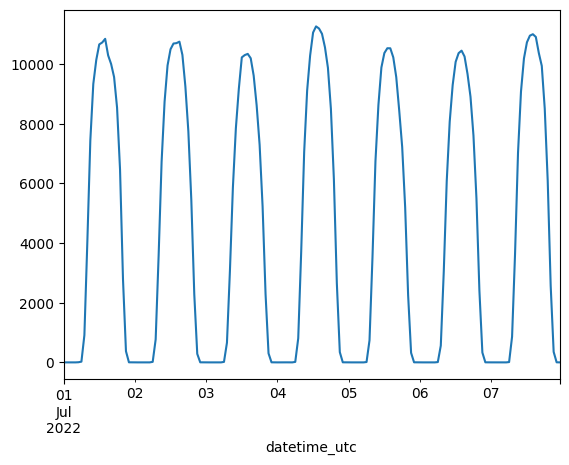

In [3]:
s_solar.plot();

## Multiplicative Model

$y_t = T_t \times S_t \times e_t$

In [4]:
df_solar = s_solar.to_frame(name='generation')
df_solar

,generation
datetime_utc,
2022-07-01 00:00:00+02:00,0.100
2022-07-01 01:00:00+02:00,0.100
2022-07-01 02:00:00+02:00,0.100
2022-07-01 03:00:00+02:00,0.100
2022-07-01 04:00:00+02:00,0.100
...,...
2022-07-07 19:00:00+02:00,6084.130
2022-07-07 20:00:00+02:00,2568.325
2022-07-07 21:00:00+02:00,352.200


In [5]:
import statsmodels.api as sm

data = df_solar['generation'].values
result = sm.tsa.seasonal_decompose(data, model='multiplicative', period=24)

df_component = (df_solar
 .assign(
    trend = result.trend,
    seasonal = result.seasonal,
    residual = result.resid)
 .dropna())

df_component['component_all'] = df_component.trend * df_component.seasonal * df_component.residual
df_component

,generation,trend,seasonal,residual,component_all
datetime_utc,,,,,
2022-07-01 12:00:00+02:00,10658.400,4673.235458,2.358597,0.966987,10658.400
2022-07-01 13:00:00+02:00,10722.100,4673.241708,2.395936,0.957605,10722.100
2022-07-01 14:00:00+02:00,10845.200,4673.241708,2.403090,0.965716,10845.200
2022-07-01 15:00:00+02:00,10289.381,4673.241708,2.353735,0.935435,10289.381
2022-07-01 16:00:00+02:00,10001.975,4673.241708,2.239531,0.955675,10001.975
...,...,...,...,...,...
2022-07-07 07:00:00+02:00,861.858,4655.687833,0.164421,1.125884,861.858
2022-07-07 08:00:00+02:00,3636.675,4671.169188,0.769768,1.011391,3636.675
2022-07-07 09:00:00+02:00,7027.300,4675.043146,1.478827,1.016449,7027.300


In [6]:
import plotly.express as px

fig = px.area(x=df_solar.index, y=df_solar['generation'], title='Original Time Series')
fig

In [7]:
dff = df_component.melt(ignore_index=False)
dff = dff.query('~variable.isin(["generation", "component_all"])')

fig = px.area(dff, x=dff.index, y='value', facet_col='variable', title='Multiplicative Model: Components of Time Series', facet_col_spacing=0.05)
fig = fig.update_yaxes(matches=None)

for axis in fig.layout:
    if 'yaxis' in axis:
        fig.layout[axis].showticklabels = True

fig

## Additive Model

$y_t = T_t + S_t + e_t$

In [8]:
import statsmodels.api as sm

data = df_solar['generation'].values
result = sm.tsa.seasonal_decompose(data, model='additive', period=24)

df_component = (df_solar
 .assign(
    trend = result.trend,
    seasonal = result.seasonal,
    residual = result.resid)
 .dropna())

df_component['component_sum'] = df_component.trend + df_component.seasonal + df_component.residual
df_component

,generation,trend,seasonal,residual,component_sum
datetime_utc,,,,,
2022-07-01 12:00:00+02:00,10658.400,4673.235458,6032.180305,-47.015763,10658.400
2022-07-01 13:00:00+02:00,10722.100,4673.241708,6197.515027,-148.656735,10722.100
2022-07-01 14:00:00+02:00,10845.200,4673.241708,6228.646277,-56.687985,10845.200
2022-07-01 15:00:00+02:00,10289.381,4673.241708,6007.261166,-391.121874,10289.381
2022-07-01 16:00:00+02:00,10001.975,4673.241708,5504.787596,-176.054305,10001.975
...,...,...,...,...,...
2022-07-07 07:00:00+02:00,861.858,4655.687833,-3716.432126,-77.397707,861.858
2022-07-07 08:00:00+02:00,3636.675,4671.169188,-1020.826445,-13.667742,3636.675
2022-07-07 09:00:00+02:00,7027.300,4675.043146,2133.608798,218.648057,7027.300


In [9]:
import plotly.express as px

In [10]:
px.area(data_frame=df_component, x=df_component.index, y='generation')

In [11]:
dff = df_component.drop(columns=['generation', 'component_sum'])
dff = dff.melt(ignore_index=False)

In [12]:
fig = px.area(dff, x=dff.index, y='value', facet_col='variable', title='Additive Model: Components of Time Series', facet_col_spacing=0.05)

for axis in fig.layout:
    if 'yaxis' in axis:
        fig.layout[axis].showticklabels = True
        
fig